# Surface Crack Binary Classification Dataset

La detección de grietas juega un rol importante en la inspección y monitoreo de estructuras civiles. Si estas no son detectadas a tiempo, su propagación puede llegar a reducir paulatinamente la resistencia de la estructura y en el peor de los casos, provocar su colapso u otro tipo de daño irreversible. En general, la inspección manual para la detección de grietas suele ser un proceso tedioso y, en ocasiones, no resulta del todo efectivo al requerir del juicio subjetivo de un experto.

Para integrar su conocimientos de Deep Learning a esta problemática, en esta tarea desarrollará modelos CNN para la detección binaria de grietas en imágenes de distinta calidad y resolución.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_02/bin/banner.png" height="180">

Cada uno de los datasets que utilizará en esta tarea contiene 2400 imágenes de superficies de hormigón con y sin grietas, junto con sus respectivas etiquetas para la clasificación. Los datasets han sido previamente separados en conjuntos de entrenamiento y testing, para una correcta evaluación de los modelos, en una proporción 80-20. De esta manera, para cada dataset tendrá 1920 imágenes para llevar a cabo el entrenamiento y 480 para testing.

Dos aspectos o consideraciones importantes a la hora de desarrollar modelos de clasificación mediante redes convolucionales son la resolución y la calidad de las imágenes a utilizar. ¿Es necesario contar con imágenes de un gran resolución para obtener buenos resultados? ¿Qué tanto influye la presencia de ruido en el desempeño de un modelo CNN?

Con el fin de determinar el efecto de estos factores, en esta tarea cuenta con los siguientes datasets en escala de grises.

- `clean_cracks_96px.npz`: dataset original con imágenes de 96x96px.
- `clean_cracks_28px.npz`: dataset original con las imágenes escaladas a 28x28px.
- `noisy_cracks_96px.npz`: dataset con imágenes con ruido uniforme agregado de 96x96px.
- `noisy_cracks_28px.npz`: dataset con imágenes con ruido uniforme agregado de 28x28px.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_02/bin/banner_2.png" height="180">

Como se mencionó anteriormente, cada uno de estos archivos cuenta con los conjuntos `X_train`, `Y_train`, `X_test` e `Y_test`, previamente definidos. En este caso, las imágenes se encuentran aplanadas en los datasets, de modo que los conjuntos `X_train` y `X_test` son de la forma `(n_samples, width*height)`. Por otro lado, vale señalar que las etiquetas `Y_train` e `Y_test` no se encuentran con `one-hot-encoding` y son de la forma `(n_samples, )`. Recuerde utilizar `np.reshape` y `keras.to_categorical` para reestructurar los arreglos a una forma compatible con las estructuras y capas de `keras`.

Para facilitar la carga de los archivos a un entorno de Google Colab, los archivos han sido cargados a un Google Drive. Copie el siguiente bloque de código en su Notebook para ejecutar la rutina de descarga. Los archivos serán cargados en el directorio `\content\datasets`.


In [1]:
!pip install -U -q PyDrive

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# inicializar GoogleDrive con credenciales de autorización
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# crear carpeta para descargar los archivos .npz
!mkdir /content/datasets

# Google Drive IDs para descargar los archivos .npz
files_id = [('clean_cracks_28px.npz', '1_ch0hhoNdXjnAW21OKiXgwwl8UqmzdP_'),
            ('clean_cracks_96px.npz', '1d3pfc8GMVg6InF_-h0jCiG6d0uEYfuAp'),
            ('noisy_cracks_28px.npz', '1YdiNowffR9ihXoQdqR56eTNzhi1ZaVCn'),
            ('noisy_cracks_96px.npz', '1W2Civt30hWM3j1Lo4QiEHVDh15IE7ma-')]

# comenzar descarga
print('descargando datasets: ', end='')

for filename, id in files_id:
  save_path = os.path.join('/content/datasets', filename)

  # descargar y guardar en /content/datasets
  downloaded = drive.CreateFile({'id': id}) 
  downloaded.GetContentFile(save_path)

# indicar descarga terminada
print('done')

mkdir: cannot create directory ‘/content/datasets’: File exists
descargando datasets: done


## Formato de Entrega

Los entregables de esta tarea son los siguientes.
- Jupyter Notebook (.ipynb): Todo el procesamiento de la tarea debe estar contenido en un único Notebook. Considere este archivo como un informe de metodología donde se reporten todos los pasos y bloques de código utilizados para resolver el problema. **Sea ordenado**; utilice comentarios en su código y bloques de texto para mejorar la legibilidad del Notebook.

- Reporte Resultados (.pdf): Este archivo debe contener los resultados obtenidos en su tarea, junto con un análisis correspondiente. Considere este documento como la sección de Resultados y Análisis de la tarea. En este sentido, debe mantener un formato de informe estándar.

## Recomendaciones

- Active el acelerador de GPU dentro del entorno de Colab. El entrenamiento de modelos convolucionales suele requerir bastante más tiempo que el de modelos MLP o Fully Connected. En este sentido, procure también comenzar su tarea con anticipación pues no existirán extensiones de plazo para la entrega.

## 1. Classification Models

Para cada una de los 4 datasets anteriormente descritos, implemente y optimice lo que más pueda un modelo convolucional de clasificación binaria mediante `keras`. Es decir, ajuste los hiperparámetros de cada modelo tal de maximizar el `accuracy` de clasificación en un conjunto de validación `(X_val, Y_val)`. Luego, para cada uno de estos cuatro modelos CNN reporte:

- Media del accuracy en el conjunto de testing `(X_test, Y_test)` para 2 iteraciones.
- Arquitectura o esquema del modelo.
- Matriz de confusión.
- Gráfico de la función de pérdida durante el entrenamiento.

Comente sobre las diferencias de desempeño al utilizar los distintos datasets de imágenes.

In [2]:
# creacion del modelo
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from sklearn.metrics import confusion_matrix
from scipy.stats import kurtosis
from scipy.stats import skew

In [3]:
def plot_confusion_matrix(Y_true, Y_pred, target_names,
                          title='Confusion matrix',
                          cmap=None, normalize=False,
                          figsize=(5,5)):
    
    """
    given the true (Y_true) and the predicted (Y_pred) labels,
    makes the confusion matrix.
    
    :param np.array Y_true:
        the true labels of the data. (no one hot encoding).
    :param np.array Y_pred:
        the predicted labels of the data by the model. (no one hot encoding).
    :param list target_names:
        given classification classes such as [0, 1, 2] the class names,
        for example: ['high', 'medium', 'low'].
    :param str title:
        the text to display at the top of the matrix.
    :param str cmap:
        the gradient of the values displayed from matplotlib.pyplot.cm
        see http://matplotlib.org/examples/color/colormaps_reference.html
        plt.get_cmap('jet') or plt.cm.Blues.
    :param bool normalize:
        if False, plot the raw numbers, if True, plot the proportions.
        
    :reference:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        
    """
    import itertools
    
    cm = confusion_matrix(Y_true, Y_pred)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                      verticalalignment="center",
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                      verticalalignment="center",
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")
    
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
# ----------------------------------------------------------------------------
def plot_loss_function(train_info, figsize=(5,5)):
    """
    -> None
    
    this function plots de evolution of the loss function of the model 
    during the training epochs.
    
    :param train_info:
        training history of the classification model.
        
    """
    # crear figura
    plt.figure(figsize=figsize)
    
    plt.plot(train_info.history['loss'])
    plt.plot(train_info.history['val_loss'])
    
    # caracteristicas del plot
    plt.title('Model loss')
    plt.ylabel('Loss'); plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
 

In [4]:
# carga de datos
def cargaDatos(archivo, imshape):
    with np.load(archivo) as data:
        X_train = data['X_train'].reshape((-1, imshape, imshape, 1))
        Y_train = to_categorical(data['Y_train'], num_classes=2)
        X_test = data['X_test'].reshape((-1, imshape, imshape, 1))
        Y_test = data['Y_test']
    return X_train, Y_train, X_test, Y_test

def crearModelo(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(2))
    
    return model

In [27]:
def stackear(vector):
    stacked = np.stack([vector, vector, vector], axis=3)
    return stacked

In [29]:
X_train, _,_,_ = cargaDatos('/content/datasets/clean_cracks_96px.npz', 96)

print(X_train.shape)
stackear(X_train).reshape((-1,96,96,3)).shape

(1920, 96, 96, 1)


(1920, 96, 96, 3)

In [30]:
def entrenarModelo(archivo, imsize, lr=0.001, epocas=10, modelo=None):

    X_train, Y_train, X_test, Y_test = cargaDatos(archivo, imsize)

    # mostrar ejemplos al azar de las imagenes
    fig, axs = plt.subplots(3,3, figsize=(10,10))
    for ax in axs:
        it = np.random.randint(0, X_train.shape[0])
        for i in range(len(ax)):
            ax[i].imshow(X_train[it + i,:,:,0])
            ax[i].set_title(Y_train[it + i])


    # creacion del modelo
    if modelo == None:
        input_shape = (imsize, imsize, 1)
        modelo = crearModelo(input_shape)
    else:
        X_train = stackear(X_train).reshape((-1, imsize, imsize, 3))
        X_test = stackear(X_test).reshape((-1, imsize, imsize, 3))

    optim = tf.keras.optimizers.Adam(
                learning_rate=lr,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                amsgrad=False,
                name="Adam"
            )

    modelo.compile(optimizer=optim,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = modelo.fit(X_train[100:,:,:,:], Y_train[100:,:], epochs=epocas,
                         validation_data=(X_train[:100,:,:,:], Y_train[:100,:]))
    
    y_pred = np.argmax(modelo.predict(X_test), axis=1)

    plot_loss_function(history, figsize=(10,4))
    accuracy = accuracy_score(Y_test, y_pred)
    plot_confusion_matrix(Y_test, y_pred, ['Defective', 'Functional'])

    print('validation accuracy: {:1.3f}'.format(accuracy))

    return modelo, history, {'X_train': X_train, 'Y_train': Y_train, 'X_test': X_test, 'Y_test': Y_test}, accuracy


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Epoch 1/100
57/57 [==============================] - 1s 17ms/step - loss: 0.5561 - accuracy: 0.7599 - val_loss: 0.3920 - val_accuracy: 0.8700
Epoch 2/100
57/57 [==============================] - 1s 12ms/step - loss: 0.3871 - accuracy: 0.8390 - val_loss: 0.2688 - val_accuracy: 0.8800
Epoch 3/100
57/57 [==============================] - 1s 13ms/step - loss: 0.3033 - accuracy: 0.8676 - val_loss: 0.1991 - val_accuracy: 0.9500
Epoch 4/100
57/57 [==============================] - 1s 13ms/step - loss: 0.1930 - accuracy: 0.9379 - val_loss: 0.1412 - val_accuracy: 0.9700
Epoch 5/100
57/57 [==============================] - 1s 13ms/step - loss: 0.1416 - accuracy: 0.9648 - val_loss: 0.2030 - val_accuracy: 0.9400
Epoch 6/100
57/57 [==============================] - 1s 13ms/step - loss: 0.1149 - accuracy: 0.9665 - val_loss: 0.0798 - val_accuracy: 1.0000
Epoch 7/100
57/57 [==============================] - 1s 13ms/step - loss: 0.0729 - accuracy: 0.9863 - val_loss: 0.0644 - val_accuracy: 0.9900
Epoch 

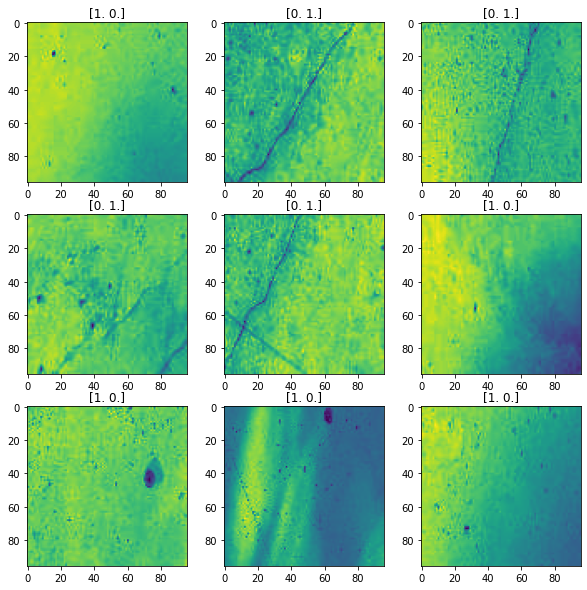

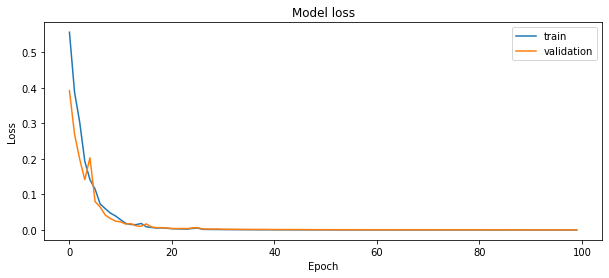

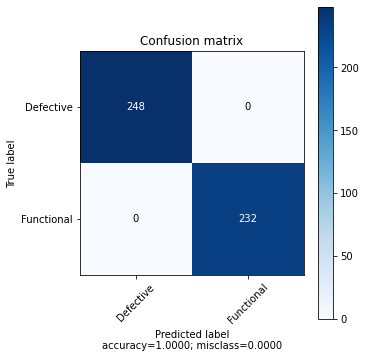

validation accuracy: 1.000
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 67712)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4333632   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              

In [6]:
modelo96c, history96c, data96clean, acc = entrenarModelo('/content/datasets/clean_cracks_96px.npz', 96, lr=0.0001, epocas=100)
modelo96c.summary()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Epoch 1/100
57/57 [==============================] - 1s 16ms/step - loss: 0.3227 - accuracy: 0.9104 - val_loss: 0.1529 - val_accuracy: 0.9400
Epoch 2/100
57/57 [==============================] - 1s 13ms/step - loss: 0.1525 - accuracy: 0.9533 - val_loss: 0.0776 - val_accuracy: 1.0000
Epoch 3/100
57/57 [==============================] - 1s 13ms/step - loss: 0.1356 - accuracy: 0.9577 - val_loss: 0.0903 - val_accuracy: 0.9800
Epoch 4/100
57/57 [==============================] - 1s 13ms/step - loss: 0.1335 - accuracy: 0.9533 - val_loss: 0.0829 - val_accuracy: 0.9800
Epoch 5/100
57/57 [==============================] - 1s 13ms/step - loss: 0.1325 - accuracy: 0.9555 - val_loss: 0.0504 - val_accuracy: 1.0000
Epoch 6/100
57/57 [==============================] - 1s 13ms/step - loss: 0.1123 - accuracy: 0.9604 - val_loss: 0.0523 - val_accuracy: 0.9900
Epoch 7/100
57/57 [==============================] - 1s 13ms/step - loss: 0.0947 - accuracy: 0.9709 - val_loss: 0.0626 - val_accuracy: 0.9800
Epoch 

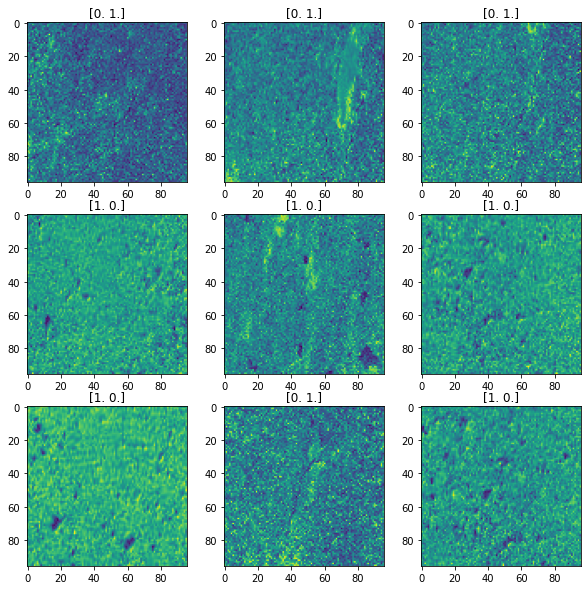

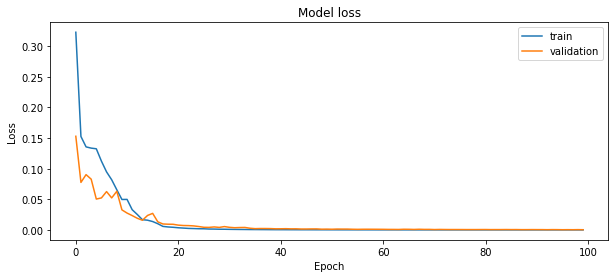

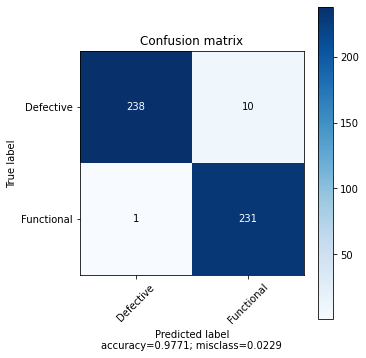

validation accuracy: 0.977
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 67712)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4333632   
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)            

In [7]:
modelo96n, history96n, data96noisy, acc = entrenarModelo('/content/datasets/noisy_cracks_96px.npz', 96, lr=0.0001, epocas=100)
modelo96n.summary()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Epoch 1/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.4923 - val_loss: 0.6931 - val_accuracy: 0.4900
Epoch 2/1000
57/57 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.7445 - val_loss: 0.6931 - val_accuracy: 0.8700
Epoch 3/1000
57/57 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.7566 - val_loss: 0.6930 - val_accuracy: 0.8700
Epoch 4/1000
57/57 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.7560 - val_loss: 0.6930 - val_accuracy: 0.8700
Epoch 5/1000
57/57 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.8385 - val_loss: 0.6929 - val_accuracy: 0.8700
Epoch 6/1000
57/57 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.8253 - val_loss: 0.6928 - val_accuracy: 0.8700
Epoch 7/1000
57/57 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.6995 - val_loss: 0.6927 - val_accuracy: 0.8700
Epoch 

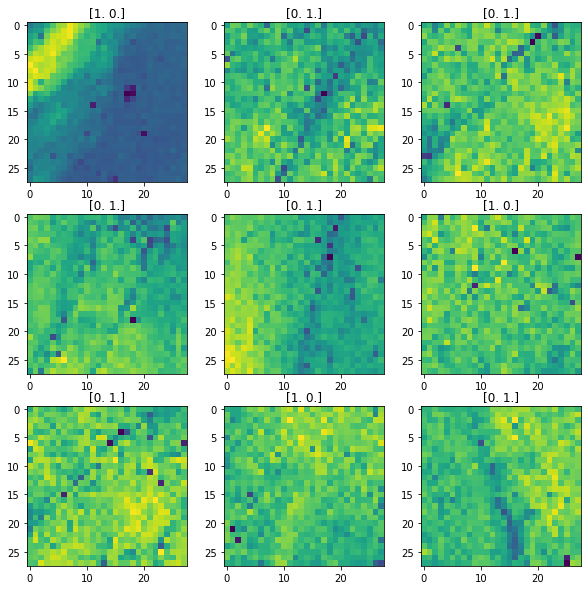

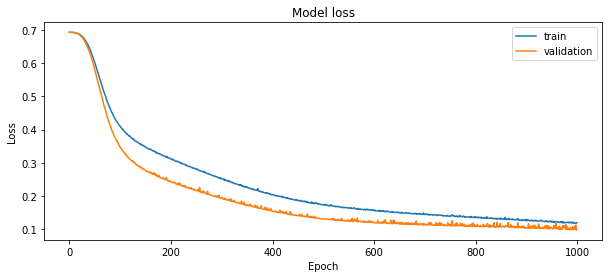

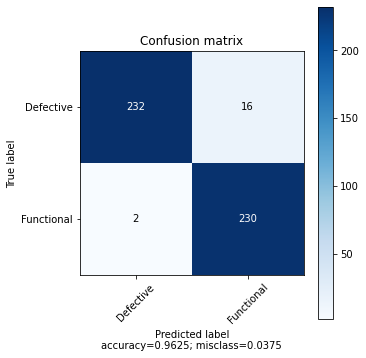

validation accuracy: 0.963
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                294976    
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)            

In [8]:
modelo28c, history28c, data28clean, acc = entrenarModelo('/content/datasets/clean_cracks_28px.npz', 28, lr=0.00001, epocas=1000)
modelo28c.summary()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Epoch 1/1000
57/57 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5665 - val_loss: 0.6930 - val_accuracy: 0.8800
Epoch 2/1000
57/57 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5588 - val_loss: 0.6929 - val_accuracy: 0.5100
Epoch 3/1000
57/57 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.6396 - val_loss: 0.6927 - val_accuracy: 0.6200
Epoch 4/1000
57/57 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.7275 - val_loss: 0.6925 - val_accuracy: 0.9200
Epoch 5/1000
57/57 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.7703 - val_loss: 0.6923 - val_accuracy: 0.8500
Epoch 6/1000
57/57 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.7797 - val_loss: 0.6919 - val_accuracy: 0.8900
Epoch 7/1000
57/57 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.7659 - val_loss: 0.6916 - val_accuracy: 0.9000
Epoch 

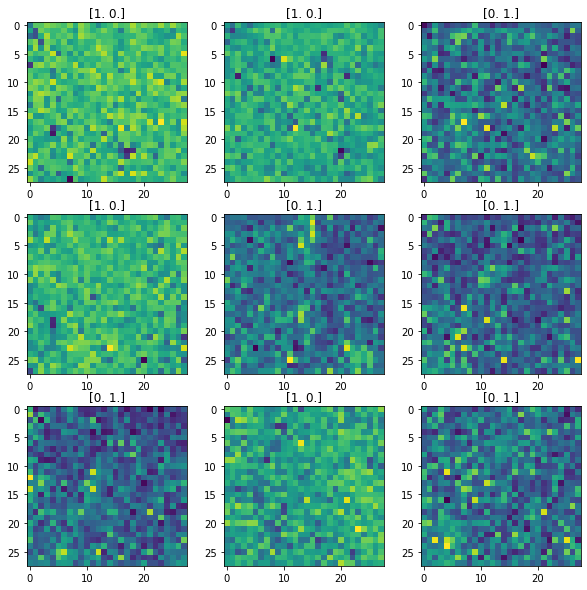

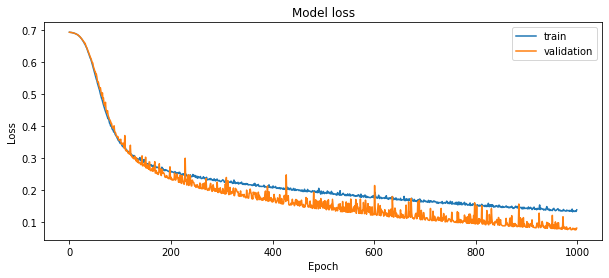

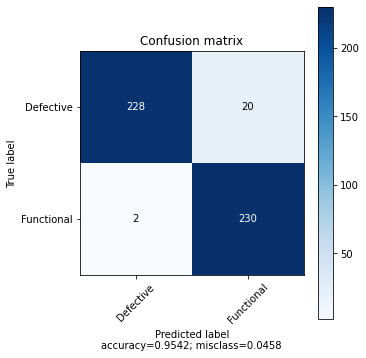

validation accuracy: 0.954
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                294976    
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)           

In [9]:
modelo28n, history28n, data28noisy, acc = entrenarModelo('/content/datasets/noisy_cracks_28px.npz', 28, lr=0.00001, epocas=1000)
modelo28n.summary()

## 2. Transfer Learning
Similar al VGG-16, el ResNet es un modelo convolucional desarrollado por el equipo de Microsoft como arquitectura de visión computacional. Propuesto en el paper Deep Residual Learning for Image Recognition (2015), ResNet ganó el concurso ILSRVC 2015 superando el desempeño humano sobre el ImageNet dataset.

https://keras.io/api/applications/resnet/#resnet50-function

Mediante transfer learning, utilice la sección convolucional de ResNet50 para construir un modelo de clasificación de grietas. En particular, los pesos de la sección ResNet deben permanecer congelados durante el entrenamiento de este nuevo modelo.

Entrene este modelo sobre los datasets `clean_cracks_96px` y `noisy_cracks_96px`. Para cada uno reporte:
- Media del accuracy en el conjunto de testing `(X_test, Y_test)` para 2 iteraciones.
- Matriz de confusión.
- Gráfico de la función de pérdida durante el entrenamiento.

Comente sobre las diferencias de desempeño respecto a los resultados de la Parte 1.


In [14]:
from keras.applications import ResNet50
from keras.models import Model

In [67]:
input_shape = (96, 96, 3)
ResNet = ResNet50(include_top=False,
                  weights="imagenet",
                  input_shape=input_shape)

input = ResNet.input
ResNet_output = ResNet.layers[-1].output

ResNet_model = Model(input, ResNet_output)

for layer in ResNet_model.layers:
  layer.trainable = False

model = layers.MaxPool2D(pool_size=(2,2))
model = layers.Flatten()(ResNet_output)

model = layers.Dense(units=64, activation='relu')(model)
model = layers.Dense(units=32, activation='relu')(model)
model = layers.Dense(units=32, activation='relu')(model)

labels_num = 2
model_output = layers.Dense(units=labels_num, activation='softmax')(model)

ResNet_model = Model(input, model_output)

ResNet_model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [68]:
X_train, Y_train, X_test, Y_test = cargaDatos('/content/datasets/clean_cracks_96px.npz', 96)
imsize = 96
X_train = stackear(X_train).reshape((-1, imsize, imsize, 3))
X_test = stackear(X_test).reshape((-1, imsize, imsize, 3))

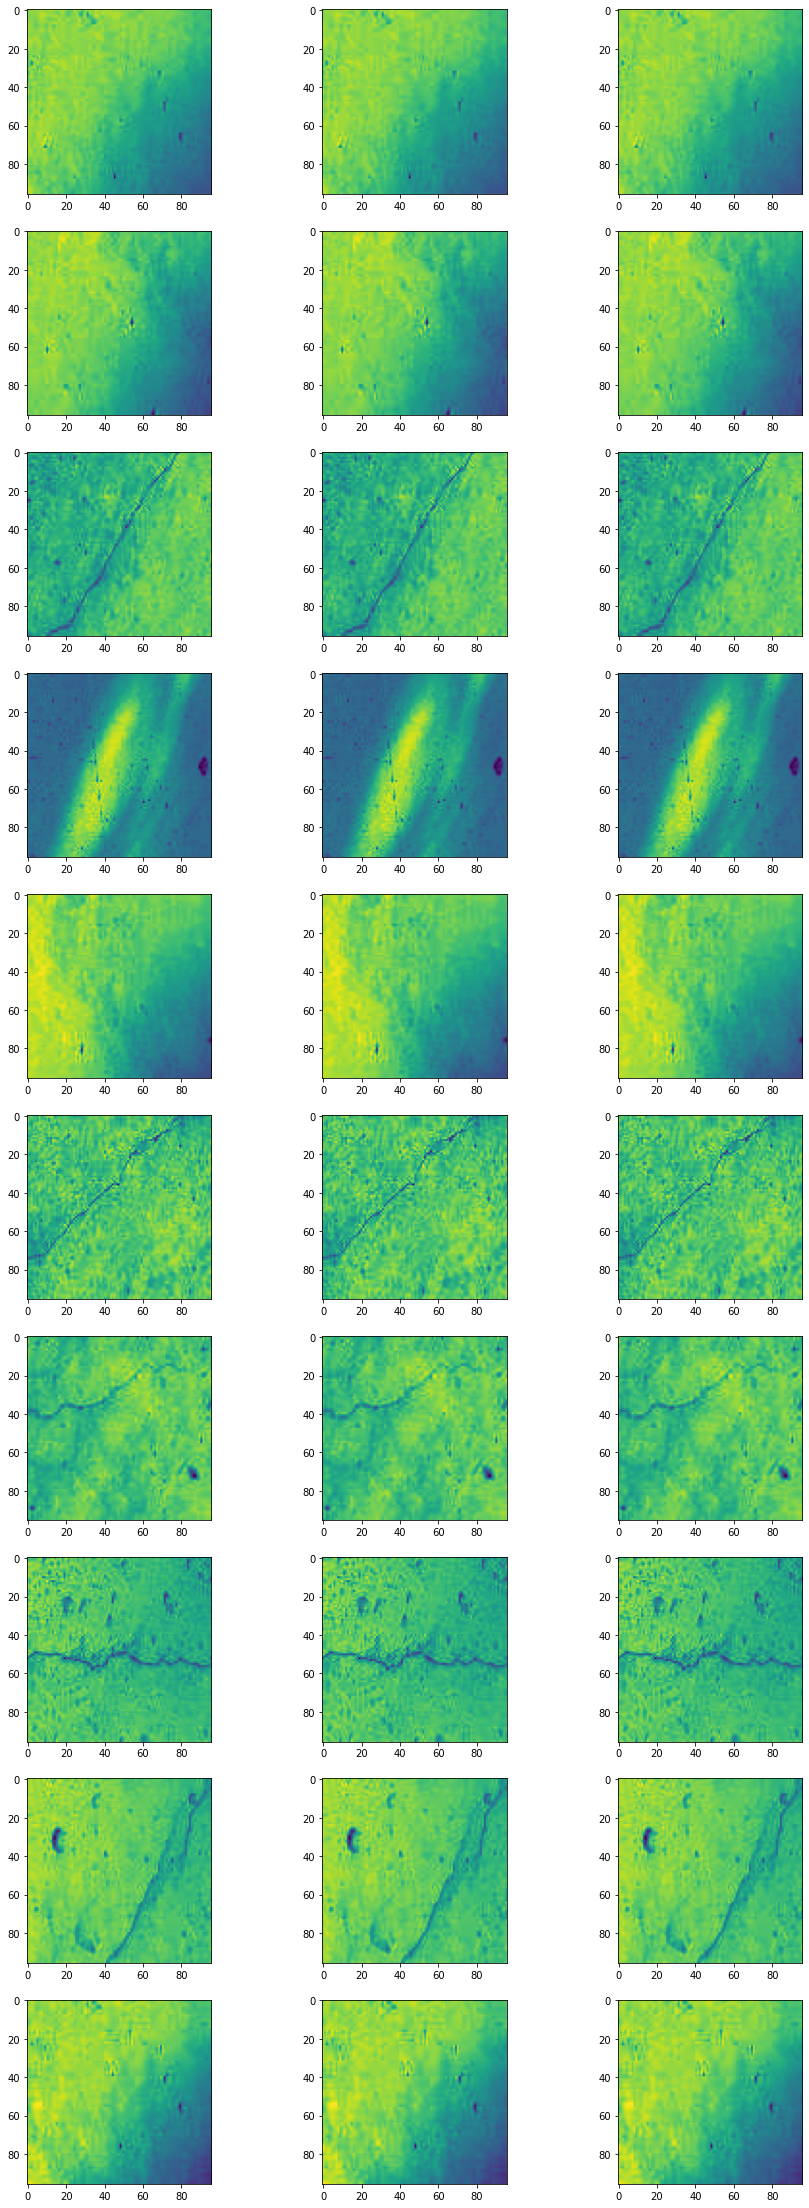

In [69]:
fig, axs = plt.subplots(10, 3, figsize=(15,40))
for idx in range(10):
    n = np.random.randint(0, X_train.shape[0])
    for i, ax in enumerate(axs[idx,:]):
        ax.imshow(X_train[n,:,:,i])

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Epoch 1/1000
57/57 [==============================] - 2s 41ms/step - loss: 0.6725 - accuracy: 0.6890 - val_loss: 0.6704 - val_accuracy: 0.6600
Epoch 2/1000
57/57 [==============================] - 1s 26ms/step - loss: 0.6719 - accuracy: 0.7159 - val_loss: 0.6704 - val_accuracy: 0.7600
Epoch 3/1000
57/57 [==============================] - 1s 26ms/step - loss: 0.6716 - accuracy: 0.7571 - val_loss: 0.6701 - val_accuracy: 0.7200
Epoch 4/1000
57/57 [==============================] - 1s 26ms/step - loss: 0.6715 - accuracy: 0.7571 - val_loss: 0.6698 - val_accuracy: 0.7200
Epoch 5/1000
57/57 [==============================] - 2s 26ms/step - loss: 0.6712 - accuracy: 0.7148 - val_loss: 0.6695 - val_accuracy: 0.7200
Epoch 6/1000
57/57 [==============================] - 1s 26ms/step - loss: 0.6708 - accuracy: 0.7055 - val_loss: 0.6692 - val_accuracy: 0.8400
Epoch 7/1000
57/57 [==============================] - 1s 26ms/step - loss: 0.6702 - accuracy: 0.7148 - val_loss: 0.6689 - val_accuracy: 0.8500

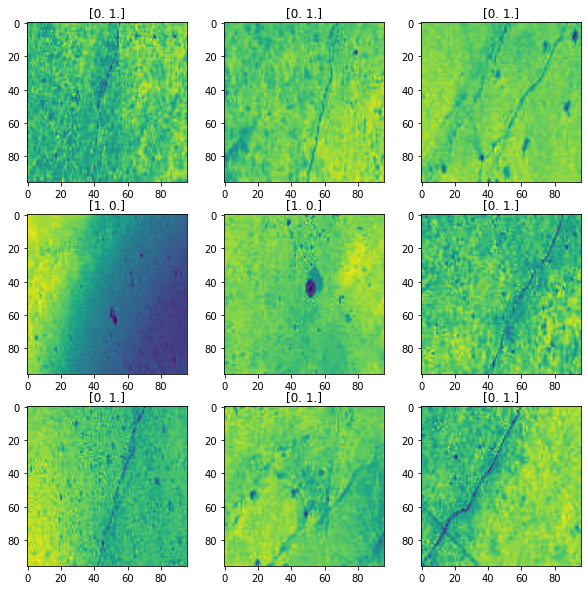

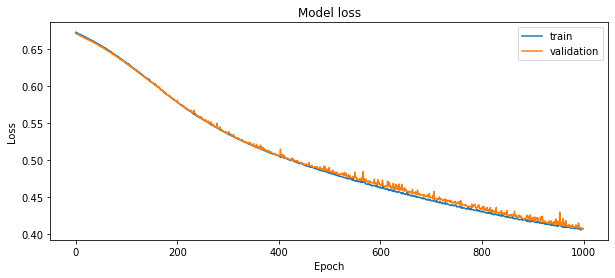

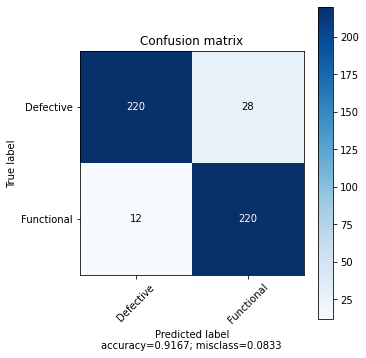

validation accuracy: 0.917


In [72]:
modeloRN96c, historyRN96c, data1, acc = entrenarModelo('/content/datasets/clean_cracks_96px.npz', 96, lr=0.00001, epocas=1000, modelo=ResNet_model)

In [ ]:
modeloRN96c, historyRN96c, data1, acc = entrenarModelo('/content/datasets/noisy_cracks_96px.npz', 96, lr=0.00001, epocas=500, modelo=ResNet_model)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Epoch 1/500
57/57 [==============================] - 2s 41ms/step - loss: 0.8248 - accuracy: 0.4874 - val_loss: 0.8033 - val_accuracy: 0.5100
Epoch 2/500
57/57 [==============================] - 1s 26ms/step - loss: 0.8148 - accuracy: 0.4978 - val_loss: 0.8033 - val_accuracy: 0.5100
Epoch 3/500
57/57 [==============================] - 1s 25ms/step - loss: 0.8124 - accuracy: 0.5000 - val_loss: 0.8033 - val_accuracy: 0.5100
Epoch 4/500
57/57 [==============================] - 1s 26ms/step - loss: 0.8110 - accuracy: 0.5022 - val_loss: 0.8033 - val_accuracy: 0.5100
Epoch 5/500
57/57 [==============================] - 1s 26ms/step - loss: 0.8103 - accuracy: 0.5027 - val_loss: 0.8033 - val_accuracy: 0.5100
Epoch 6/500
57/57 [==============================] - 1s 26ms/step - loss: 0.8100 - accuracy: 0.5033 - val_loss: 0.8033 - val_accuracy: 0.5100
Epoch 7/500
57/57 [==============================] - 1s 26ms/step - loss: 0.8099 - accuracy: 0.5033 - val_loss: 0.8033 - val_accuracy: 0.5100
Epoch 